## 1. Baseline Model on Test Dataset


Loading pre-trained model...
Initializing Relation Encoder Model with bert-base-uncased


/Users/kashifmoin/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exac

Model loaded successfully!

Loading BioC JSON file: Test.BioC.JSON
Extracted 1163 relation samples.

Computing embeddings...
Computed embeddings with shape: (1163, 128)

Performing K-Means clustering with 8 clusters...
Clustering completed!


Final Relation Extraction Results:
Relation Text			True Label	Predicted Label
D001919 - Association - 6331  →  True: Association | Predicted: Conversion
D001919 - Positive_Correlation - p|SUB|V|1763|M  →  True: Positive_Correlation | Predicted: Drug_Interaction
D013610 - Association - 6331  →  True: Association | Predicted: Conversion
D013610 - Positive_Correlation - p|SUB|V|1763|M  →  True: Positive_Correlation | Predicted: Drug_Interaction
6331 - Association - D001145  →  True: Association | Predicted: Association
D001145 - Negative_Correlation - D008801  →  True: Negative_Correlation | Predicted: Negative_Correlation
D001145 - Negative_Correlation - D008012  →  True: Negative_Correlation | Predicted: Negative_Correlation
p|SUB|V|1763|M - Positi

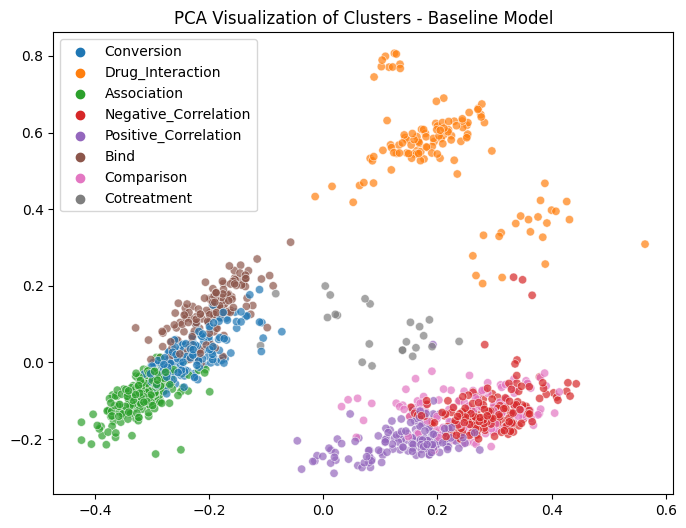

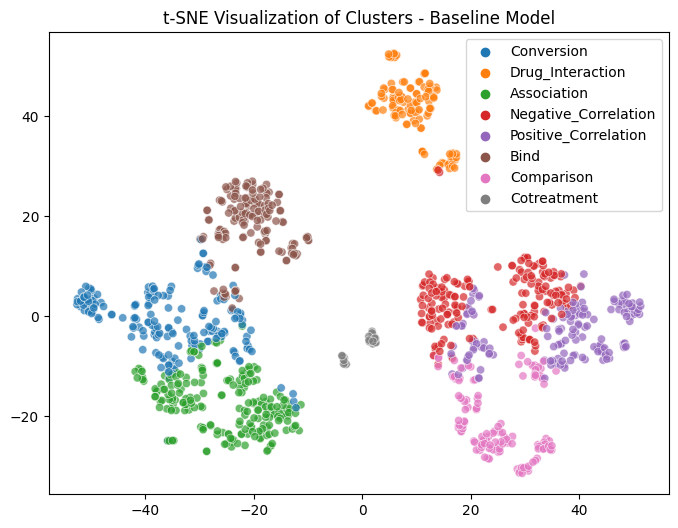

Evaluation Complete!


In [ ]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, silhouette_score, calinski_harabasz_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE
import umap


# Loading Dataset (BioC JSON)
class BioCDataset:
    def __init__(self, file_path):
        print(f"Loading BioC JSON file: {file_path}")
        with open(file_path, "r") as f:
            data = json.load(f)

        self.samples = []
        self.labels = []

        for doc in data["documents"]:
            for rel in doc["relations"]:
                infons = rel.get("infons", {})
                entity1 = infons.get("entity1", "Entity1")
                entity2 = infons.get("entity2", "Entity2")
                rel_type = infons.get("type", "UnknownRelation")
                rel_text = f"{entity1} - {rel_type} - {entity2}"
                self.samples.append(rel_text)
                self.labels.append(rel_type)  # True relation labels

        print(f"Extracted {len(self.samples)} relation samples.\n")

    def get_samples(self):
        return self.samples, self.labels


# Defining Relation Encoder Model

  """   Initializing the Relation Encoder model using a pre-trained BERT model.
        Adding a fully connected layer to project BERT's CLS token output to a 128-dimensional embedding.
        Parameters:
            pretrained_model_name (str): The name of the pre-trained BERT model."""
class RelationEncoder(torch.nn.Module):
    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(RelationEncoder, self).__init__()
        print(f"Initializing Relation Encoder Model with {pretrained_model_name}")
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.fc = torch.nn.Linear(self.bert.config.hidden_size, 128)
        
        """Performing a forward pass through the model.
      Parameters:
            input_ids (torch.Tensor): Tensor of token IDs.
            attention_mask (torch.Tensor): Tensor for attention masking.
        Returns:
            torch.Tensor: Normalized 128-dimensional embedding for each input sequence.
            """
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        emb = self.fc(cls)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
        return emb


# Loading Pretrained Model & Tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nLoading pre-trained model...")
model = RelationEncoder().to(device)

# Using strict=False to avoid missing key errors
model.load_state_dict(torch.load("baseline_model.pth", map_location=device), strict=False)

model.eval()
print("Model loaded successfully!\n")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")



#Extracting Embeddings for Evaluation
""" Computing normalized embeddings for the input texts using the provided model and tokenizer.
    Parameters:
        model (torch.nn.Module): The relation encoder model.
        texts (list): List of relation text strings.
        tokenizer: Tokenizer for the model.
        batch_size (int): Number of texts to process in each batch.
    Returns:
        np.ndarray: Concatenated embeddings for all texts."""

def extract_embeddings(model, texts, tokenizer, batch_size=16):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i : i + batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            emb = model(inputs["input_ids"], inputs["attention_mask"])
            embeddings.append(emb.cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

# Loading test dataset
test_dataset = BioCDataset("Test.BioC.JSON")
relation_texts, true_labels = test_dataset.get_samples()

# Extracting embeddings
print("Computing embeddings...")
embeddings = extract_embeddings(model, relation_texts, tokenizer)
print(f"Computed embeddings with shape: {embeddings.shape}\n")


#Performing Clustering (K-Means)
num_clusters = len(set(true_labels))
print(f"Performing K-Means clustering with {num_clusters} clusters...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
predicted_labels = kmeans.fit_predict(embeddings)
print("Clustering completed!\n")

# Maping Cluster Labels to True Labels
def map_cluster_labels(true_labels, predicted_labels):
    label_names = list(set(true_labels))
    true_numeric = [label_names.index(x) for x in true_labels]
    cm = confusion_matrix(true_numeric, predicted_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    mapped_predicted = [mapping[p] for p in predicted_labels]
    mapped_predicted_labels = [label_names[x] for x in mapped_predicted]
    return mapped_predicted_labels, label_names

mapped_predicted_labels, label_names = map_cluster_labels(true_labels, predicted_labels)


# Printing Evaluation Results
print("\nFinal Relation Extraction Results:")
print("Relation Text\t\t\tTrue Label\tPredicted Label")
for text, t_label, p_label in zip(relation_texts[:10], true_labels[:10], mapped_predicted_labels[:10]):
    print(f"{text}  →  True: {t_label} | Predicted: {p_label}")

# Computing Precision, Recall, F1-score
report = classification_report(true_labels, mapped_predicted_labels, target_names=label_names, zero_division=0)
print("\nClassification Report:\n", report)

accuracy = np.mean(np.array(true_labels) == np.array(mapped_predicted_labels))
precision = precision_score(true_labels, mapped_predicted_labels, average="macro", zero_division=0)
recall = recall_score(true_labels, mapped_predicted_labels, average="macro", zero_division=0)
f1 = f1_score(true_labels, mapped_predicted_labels, average="macro", zero_division=0)

print("\nEvaluation Summary:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}\n")


# Clustering Performance Metrics
silhouette = silhouette_score(embeddings, predicted_labels)
calinski = calinski_harabasz_score(embeddings, predicted_labels)

print("\nClustering Performance Metrics:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Score: {calinski:.4f}\n")


# Visualization (PCA, t-SNE)
print("Performing PCA for visualization...")
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

print("Performing t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Function to plot clusters
def plot_embedding(embedding, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=mapped_predicted_labels, palette="tab10", alpha=0.7)
    plt.title(title)
    plt.show()

# Generating plots
plot_embedding(pca_embeddings, "PCA Visualization of Clusters - Baseline Model")
plot_embedding(tsne_embeddings, "t-SNE Visualization of Clusters - Baseline Model")

print("Evaluation Complete!")

In [ ]:
# Preparing dictionary with proper metric names using the computed variables
metrics_model1 = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Silhouette': silhouette,
}

## 2. Trained Model on Test Dataset


Loading pre-trained model...
Initializing Relation Extraction Model with microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/var/folders/jv/npx4rz354hb929cw_lzlxh_80000gn/T/ipykernel_29240/3786435064.py:105: Futu

Model loaded successfully!



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Loading BioC JSON file: Test.BioC.JSON
Successfully loaded Test.BioC.JSON, containing 100 documents.

Extracting relations and labels from BioC JSON data...
Extracted 1163 relations from dataset.

Computing embeddings for extracted relations...
Computed embeddings with shape: (1163, 768)

Performing K-Means clustering with 8 clusters...
Clustering completed!

Mapping predicted clusters to true labels using Hungarian algorithm...
Found 8 unique relation types.
Cluster labels successfully mapped to true relation labels!


Final Relation Extraction Results:
Relation Text			True Label	Predicted Label
D001919 - Association - 6331  →  True: Association | Predicted: Conversion
D001919 - Positive_Correlation - p|SUB|V|1763|M  →  True: Positive_Correlation | Predicted: Positive_Correlation
D013610 - Association - 6331  →  True: Association | Predicted: Conversion
D013610 - Positive_Correlation - p|SUB|V|1763|M  →  True: Positive_Correlation | Predicted: Positive_Correlation
6331 - Association -

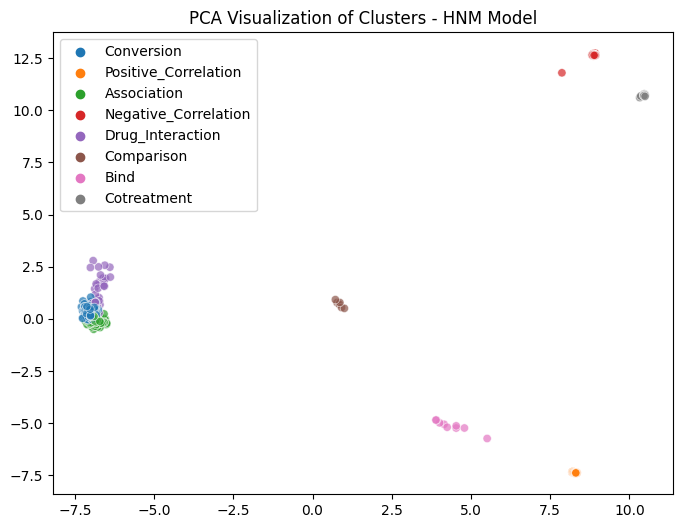

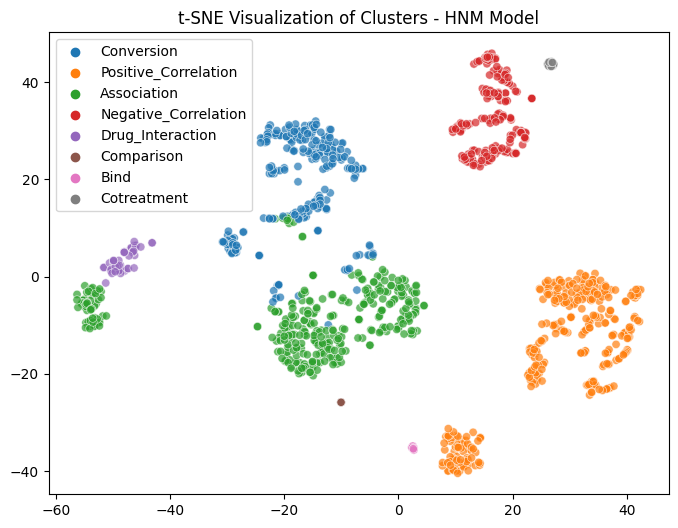

Evaluation Complete!


In [ ]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix, classification_report, silhouette_score,
    calinski_harabasz_score, precision_score, recall_score, f1_score
)
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE
import umap

#Defining Helper Functions

def load_bioc_file(filename):
    """Load a BioC JSON file."""
    print(f"Loading BioC JSON file: {filename}")
    with open(filename, "r") as f:
        data = json.load(f)
    print(f"Successfully loaded {filename}, containing {len(data.get('documents', []))} documents.\n")
    return data

def extract_relation_texts_and_labels(bioc_data):
    """Extract relation texts and true labels from a BioC JSON structure."""
    print("Extracting relations and labels from BioC JSON data...")

    relation_texts = []
    true_labels = []

    for doc in bioc_data.get("documents", []):
        for rel in doc.get("relations", []):
            infons = rel.get("infons", {})
            entity1 = infons.get("entity1", "Entity1")
            entity2 = infons.get("entity2", "Entity2")
            rel_type = infons.get("type", "Relation")

            rel_text = f"{entity1} - {rel_type} - {entity2}"
            relation_texts.append(rel_text)
            true_labels.append(rel_type)

    print(f"Extracted {len(relation_texts)} relations from dataset.\n")
    return relation_texts, true_labels

def get_embedding(text, tokenizer, model):
    """Compute the embedding for a given relation text using the model."""
    try:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embedding = model(inputs["input_ids"], inputs["attention_mask"])
        return embedding.squeeze(0).cpu().numpy()
    except Exception as e:
        print(f"Error computing embedding for: '{text}'\nError: {e}")
        return None

def map_cluster_labels(true_labels, predicted_labels):
    """Maping unsupervised cluster labels (predicted_labels) to the true labels using the Hungarian algorithm."""
    print("Mapping predicted clusters to true labels using Hungarian algorithm...")

    label_names = list(set(true_labels))
    print(f"Found {len(label_names)} unique relation types.")

    true_numeric = [label_names.index(x) for x in true_labels]
    cm = confusion_matrix(true_numeric, predicted_labels)

    row_ind, col_ind = linear_sum_assignment(-cm)

    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    mapped_predicted = [mapping[p] for p in predicted_labels]

    mapped_predicted_labels = [label_names[x] for x in mapped_predicted]

    print("Cluster labels successfully mapped to true relation labels!\n")

    return mapped_predicted_labels, label_names


# Defining the Relation Extraction Model
class RelationExtractionModel(torch.nn.Module):
    def __init__(self, bert_model_name="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", embedding_dim=768):
        super(RelationExtractionModel, self).__init__()
        print(f"Initializing Relation Extraction Model with {bert_model_name}")
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = torch.nn.Dropout(p=0.1)
        self.fc = torch.nn.Linear(embedding_dim, embedding_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        cls_output = self.dropout(cls_output)
        relation_embedding = self.fc(cls_output)
        return relation_embedding


# Loading the Saved Pretrained Model

print("\nLoading pre-trained model...")
model = RelationExtractionModel()
model.load_state_dict(torch.load("trained_relation_extraction_model.pth", map_location=torch.device("cpu")), strict=False)
model.eval()
print("Model loaded successfully!\n")

tokenizer = BertTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")

# Loading Test Data and Extract Relations
test_bioc_data = load_bioc_file("Test.BioC.JSON")
relation_texts, true_labels = extract_relation_texts_and_labels(test_bioc_data)

# Computing Embeddings for Each Relation
print("Computing embeddings for extracted relations...")
embeddings = [get_embedding(text, tokenizer, model) for text in relation_texts]
embeddings = np.array([emb for emb in embeddings if emb is not None])

if embeddings.shape[0] == 0:
    print("No embeddings computed. Exiting.")
    exit()

print(f"Computed embeddings with shape: {embeddings.shape}\n")

# Clustering the Embeddings to Get Predicted Labels
num_clusters = len(set(true_labels))
print(f"Performing K-Means clustering with {num_clusters} clusters...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
predicted_labels = kmeans.fit_predict(embeddings)
print("Clustering completed!\n")


# Maping Cluster Labels to True Labels and Print Results

mapped_predicted_labels, label_names = map_cluster_labels(true_labels, predicted_labels)

print("\nFinal Relation Extraction Results:")
print("Relation Text\t\t\tTrue Label\tPredicted Label")
for text, t_label, p_label in zip(relation_texts[:10], true_labels[:10], mapped_predicted_labels[:10]):
    print(f"{text}  →  True: {t_label} | Predicted: {p_label}")


# Printing Summary Metrics
report = classification_report(true_labels, mapped_predicted_labels, target_names=label_names, zero_division=0)
print("\nClassification Report:\n", report)

# Computing overall precision, recall, and F1-score
precision = precision_score(true_labels, mapped_predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, mapped_predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, mapped_predicted_labels, average='weighted', zero_division=0)

correct_predictions = sum(1 for t, p in zip(true_labels, mapped_predicted_labels) if t == p)
accuracy = correct_predictions / len(true_labels)

print("\nEvaluation Summary:")
print(f"Total relations: {len(true_labels)}")
print(f"Correctly classified relations: {correct_predictions}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Evaluation Complete!\n")

# Clustering Performance Metrics
silhouette = silhouette_score(embeddings, predicted_labels)
calinski = calinski_harabasz_score(embeddings, predicted_labels)

print("\nClustering Performance Metrics:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Score: {calinski:.4f}\n")


# Visualization (PCA, t-SNE)

print("Performing PCA for visualization...")
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

print("Performing t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)


# Plot function
def plot_embedding(embedding, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=mapped_predicted_labels, palette="tab10", alpha=0.7)
    plt.title(title)
    plt.show()

plot_embedding(pca_embeddings, "PCA Visualization of Clusters - HNM Model")
plot_embedding(tsne_embeddings, "t-SNE Visualization of Clusters - HNM Model")

print("Evaluation Complete!")

In [ ]:
# Preparing dictionary with proper metric names using the computed variables
metrics_model2 = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Silhouette': silhouette,
}

## Model Comparison

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

"""
created a pandas DataFrame to compare evaluation metrics between two models:
1. Baseline Model
2. HNM Model

Each model's metrics are stored in dictionaries (metrics_model1 and metrics_model2).
The DataFrame is constructed such that each row represents one model and each column
represents a specific evaluation metric (e.g., accuracy, precision, recall). This table
provides a convenient overview for direct comparison of the models' performance.
"""

# Creating DataFrame for comparison
df = pd.DataFrame([metrics_model1, metrics_model2], index=["Baseline Model", "HNM Model"])
df

,Accuracy,Precision,Recall,F1 Score,Silhouette
Baseline Model,0.359415,0.344898,0.396138,0.274368,0.203183
HNM Model,0.755804,0.996640,0.755804,0.840581,0.593282


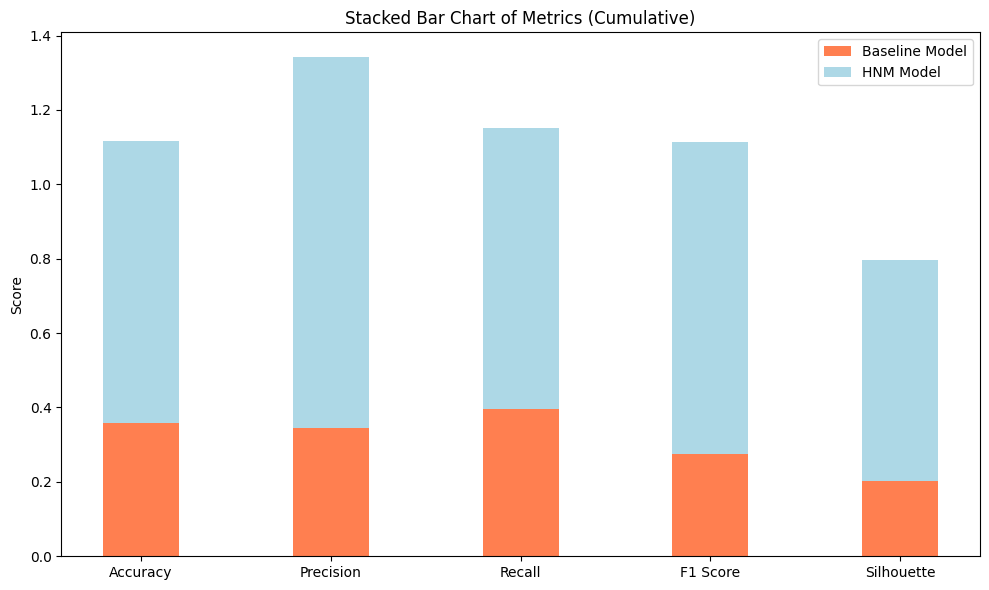

In [ ]:
"""
created a stacked bar chart to compare evaluation metrics for two models:
1. Baseline Model
2. HNM Model

For each evaluation metric, a bar is drawn where the Baseline Model's value is plotted first,
and the HNM Model's value is stacked on top. The cumulative height of each bar represents
the combined score for that metric. The x-axis shows the metric names, while the y-axis
indicates the scores. This visualization provides a clear comparison of how each model
contributes to the overall metric scores.
"""

categories = list(metrics_model1.keys())
x = np.arange(len(categories))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
indices = np.arange(len(categories))
model1_values = np.array([metrics_model1[m] for m in categories])
model2_values = np.array([metrics_model2[m] for m in categories])
# Stacked bars: HNM Model  is drawn on top of Baseline Model
ax.bar(indices, model1_values, width=0.4, label="Baseline Model", color="coral")
ax.bar(indices, model2_values, width=0.4, label="HNM Model", color="lightblue", bottom=model1_values)
ax.set_xticks(indices)
ax.set_xticklabels(categories)
ax.set_title("Stacked Bar Chart of Metrics (Cumulative)")
ax.set_ylabel("Score")
ax.legend()
plt.tight_layout()
plt.show()

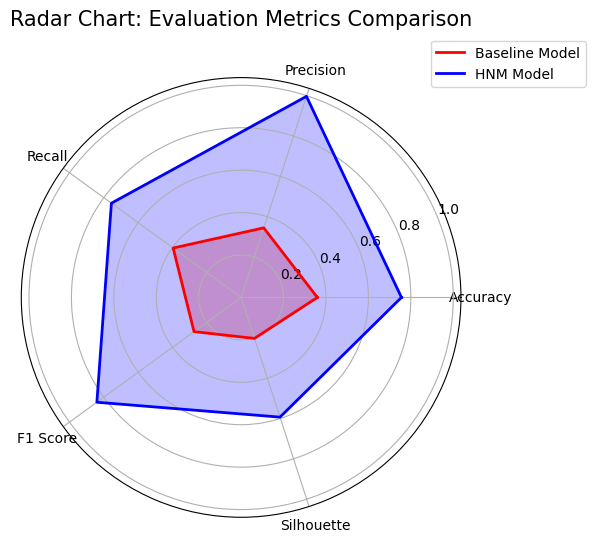

In [ ]:

"""
This creates a radar chart to compare evaluation metrics for two models:
1. Baseline Model
2. HNM Model

The radar chart plots different metrics on separate axes that radiate from the center.
Each axis represents a specific evaluation metric (like accuracy, precision, etc.).
The distance from the center along each axis corresponds to the value of that metric.
By connecting the points for each model, the chart forms a closed polygon, making it
easy to visually compare the performance of the two models across all metrics.
"""

def create_radar_chart(metrics_dict):
    categories = list(metrics_dict.keys())
    values = list(metrics_dict.values())
    # Closing the circle by repeating the first value and angle
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    return angles, values, categories

angles1, values1, categories = create_radar_chart(metrics_model1)
angles2, values2, _ = create_radar_chart(metrics_model2)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles1, values1, color='r', linewidth=2, label="Baseline Model")
ax.fill(angles1, values1, color='r', alpha=0.25)
ax.plot(angles2, values2, color='b', linewidth=2, label="HNM Model")
ax.fill(angles2, values2, color='b', alpha=0.25)
ax.set_thetagrids(np.degrees(angles1[:-1]), categories)
ax.set_title("Radar Chart: Evaluation Metrics Comparison", size=15, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()